# Visualize the hazard for the indicator "Number of days above a certain temperature"

- A workflow from the CLIMAAX [Handbook](https://handbook.climaax.eu/) and [MULTI_infrastructure](https://github.com/CLIMAAX/MULTI_infrastructure) GitHub repository.
- See our [how to use risk workflows](https://handbook.climaax.eu/notebooks/workflows_how_to.html) page for information on how to run this notebook.

After the calculation of the indicator for the Euro-Cordex dataset we plot the results for each scenario and for each time period

In [1]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import os
import xarray as xr
import re
from cartopy.mpl.ticker import (LongitudeFormatter, LatitudeFormatter)
from regionmask import mask_geopandas

ERROR 1: PROJ: proj_create_from_database: Open of /work/cmcc/dg07124/miniconda3/envs/climax/share/proj failed


In [2]:
# Read the shapefile for Italy
gdf = gpd.read_file(r'/work/cmcc/dg07124/climax/data/shp/EU/CNTR_RG_01M_2020_4326.shp')
italy = gdf[gdf.NAME_ENGL == 'Italy']

# Directory containing the NetCDF files
data_dir = r'/work/cmcc/dg07124/climax/indicators/cordex2/tempPercentiles/averaged_ensembles'
output_maps = r'/work/cmcc/dg07124/climax/indicators/cordex/maps'

# Check if output_maps exists, if not, create it
if not os.path.exists(output_maps):
    os.makedirs(output_maps)
    
# Define scenarios and thresholdss
scenarios = ['rcp26', 'rcp45', 'rcp85']
thresholds = ['p95', 'p999']
time_periods = ['2021-2050', '2041-2070', '2071-2100']

In [3]:
def paletta(vmin, vmax, step):
    """
    Generates a set of evenly spaced ticks between vmin (rounded to 0) and vmax based on the provided step size.
    Ensures that the ticks align with the color bar range.
    """
    # Force vmin to be 0
    valmin = 0
    
    # Round vmax to the nearest multiple of step
    valmax = np.ceil(vmax / step) * step

    # Create a vector of ticks from valmin to valmax
    vector_label = np.arange(valmin, valmax + step, step)

    return vector_label

Global min: 0.8241380591757869, Global max: 8.383377082237763


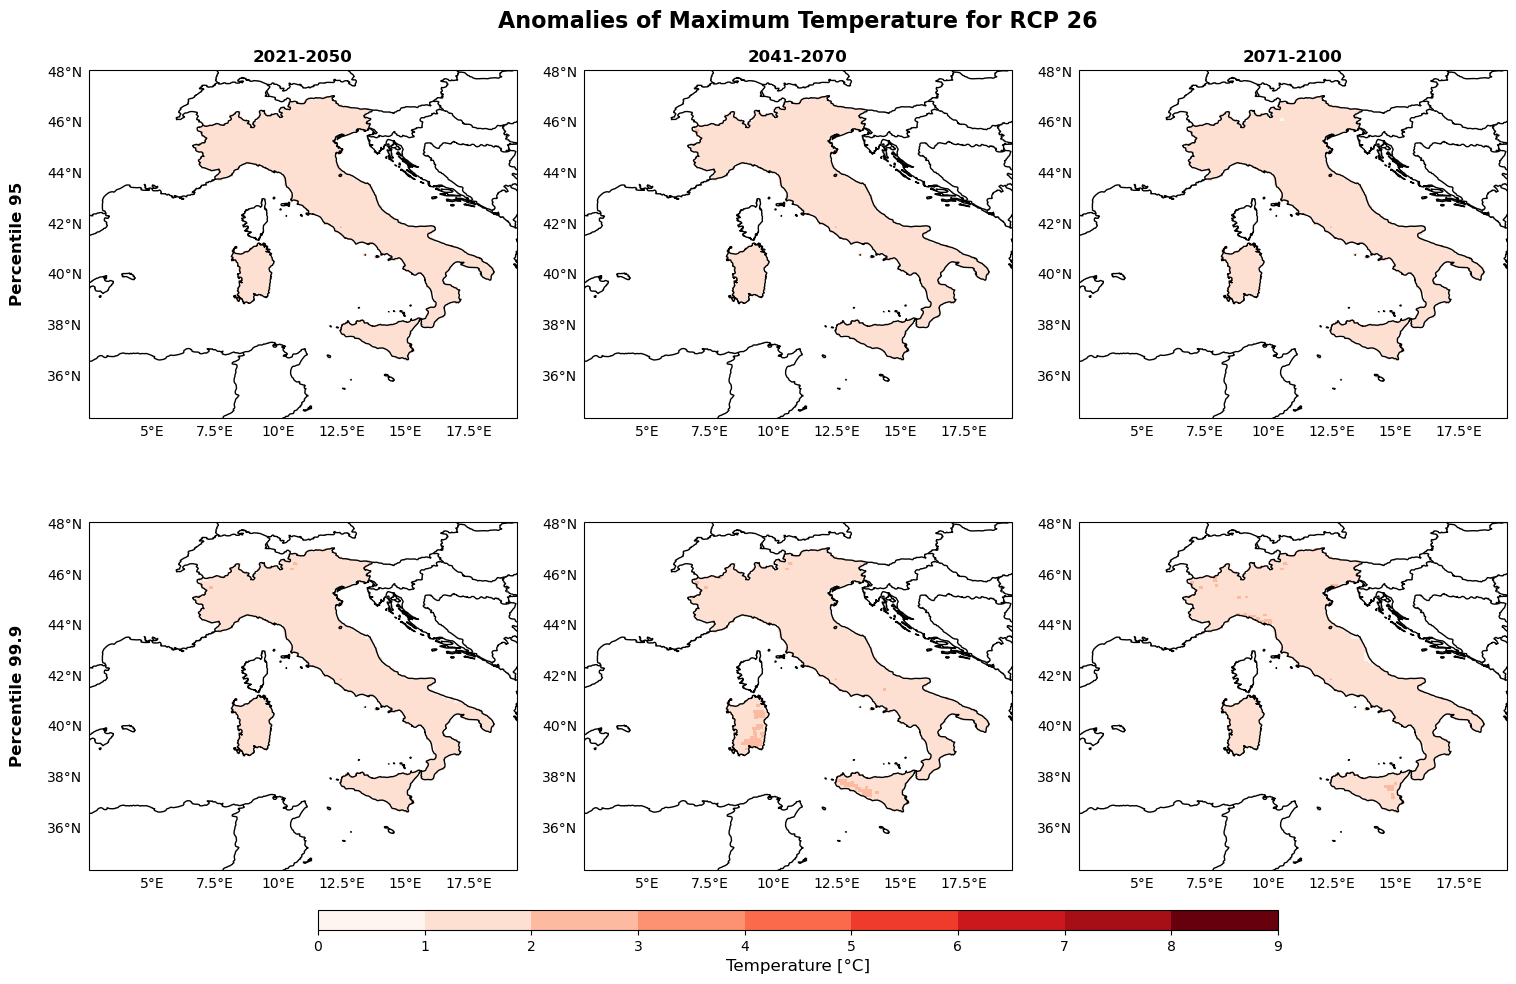

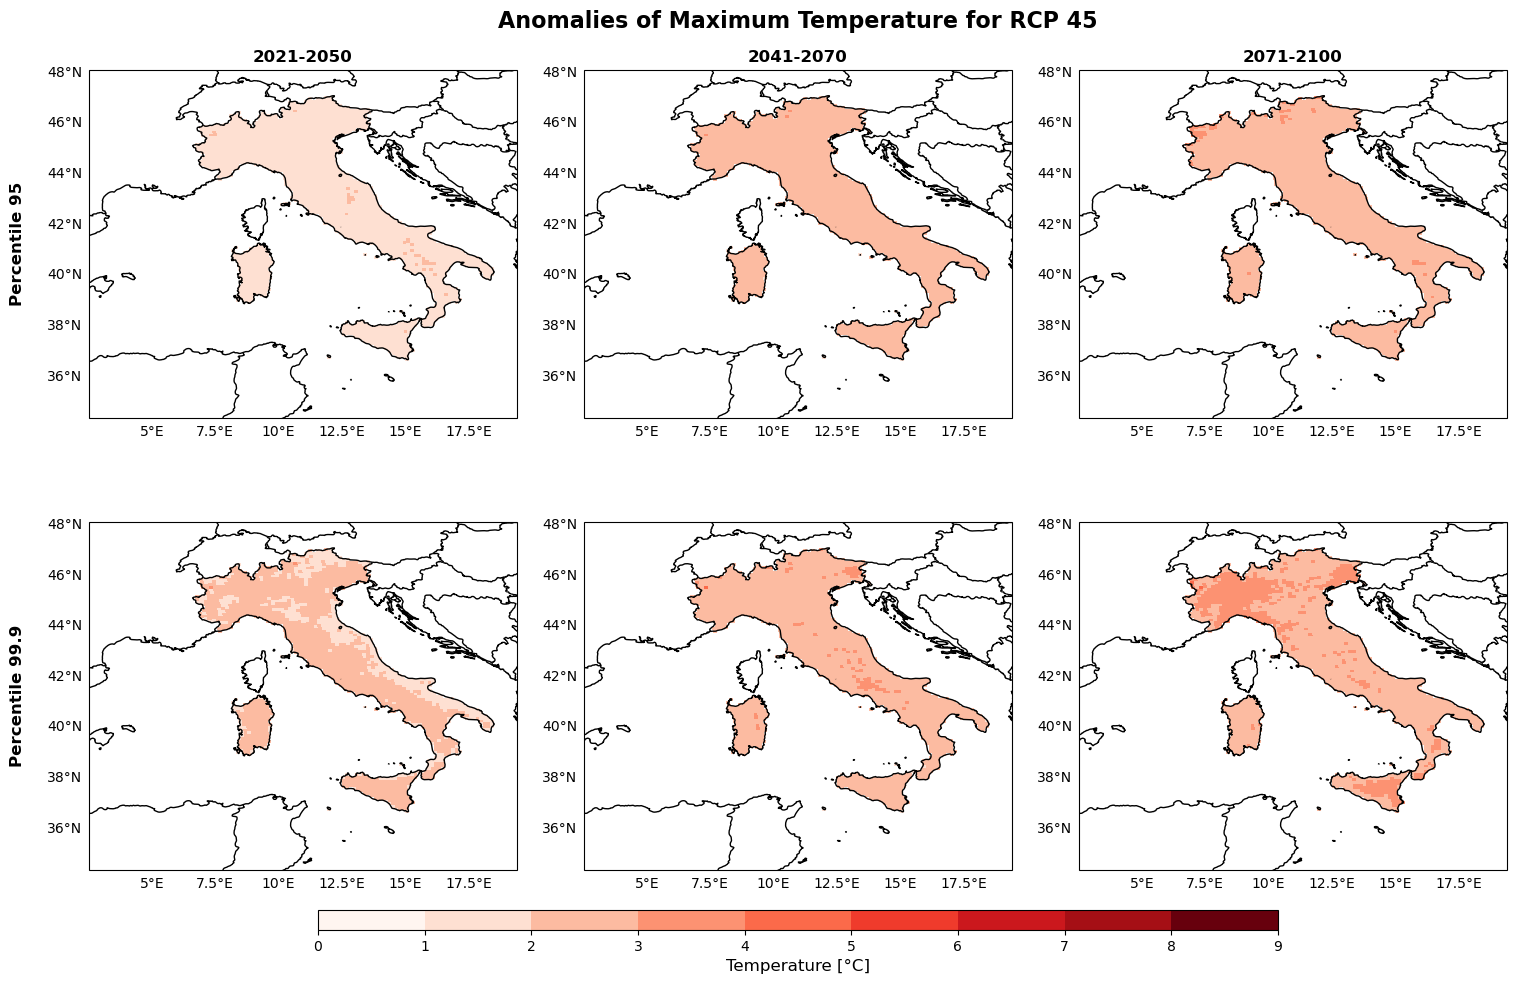

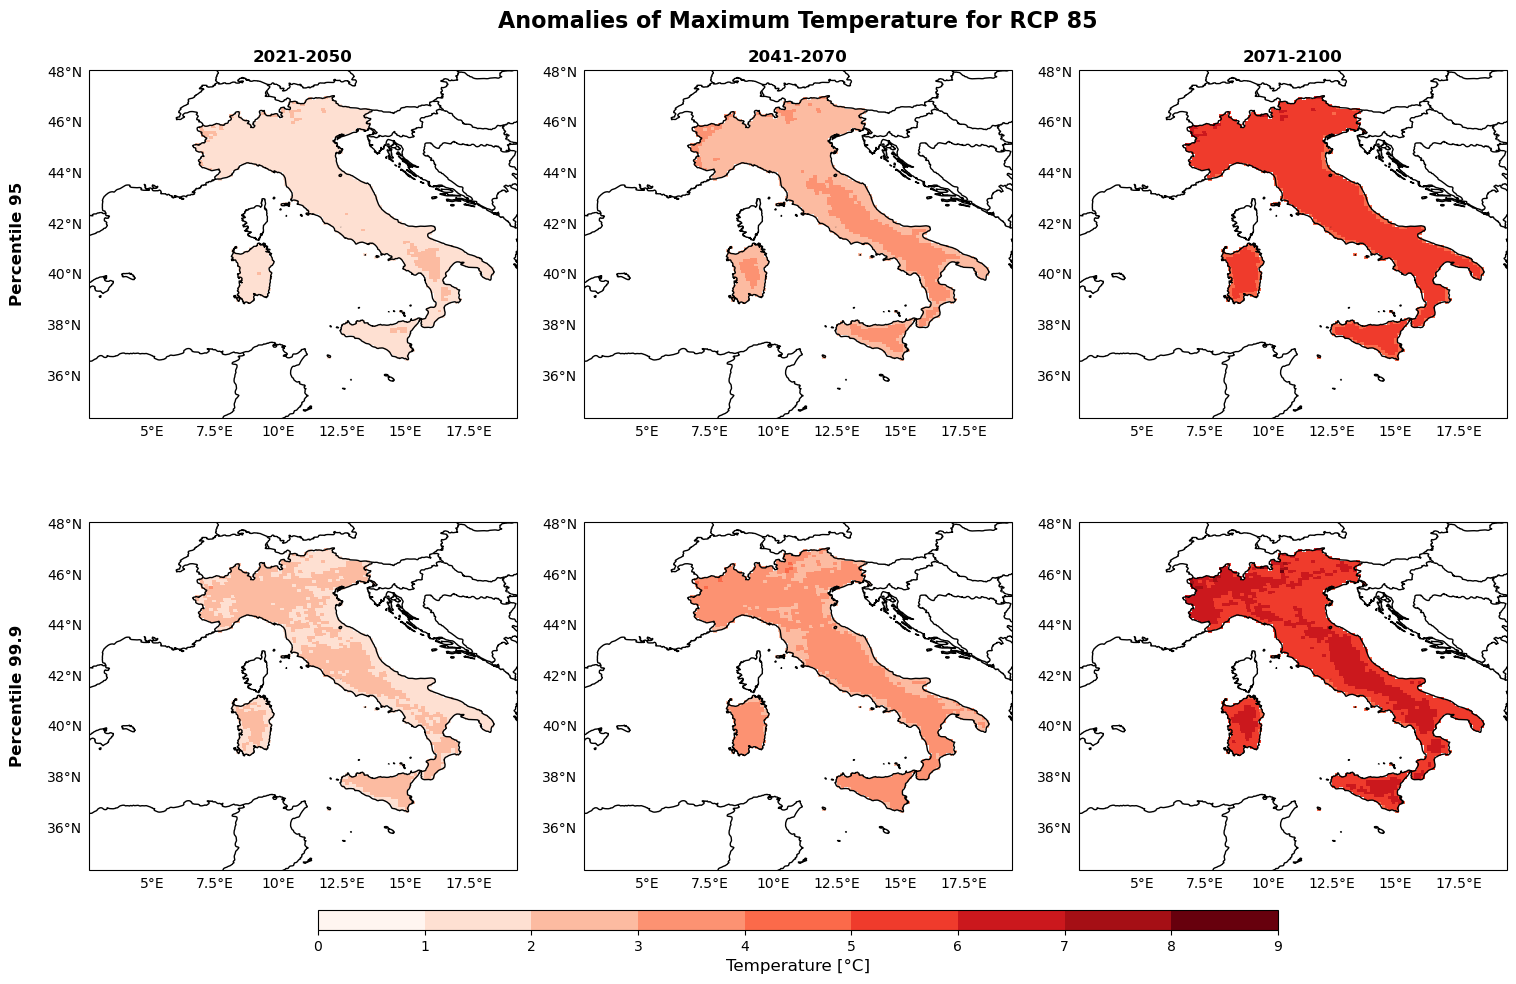

In [ ]:
# Step 1: Calculate global min and max across all files (for all scenarios, thresholds, and time periods)
masked_TempPercent_arrays = []

# Loop over all scenarios, thresholds, and time periods to gather data for global min/max
for scenario in scenarios:
    for threshold in thresholds:
        for time_period in time_periods:
            filename = f"tasmax_EUR-11_{scenario}_ensemble_{threshold}_{time_period}.nc" #tasmax_EUR-11_rcp26_ensemble_p999_2071-2100.nc
            filepath = os.path.join(data_dir, filename)
            if os.path.exists(filepath):
                ds_TempPercent = xr.open_dataset(filepath)

                # Extract the variable of interest
                var_TempPercent = ds_TempPercent['tasmax']
                lon = ds_TempPercent['lon']
                lat = ds_TempPercent['lat']

                # Create the mask for Italy
                mmask = mask_geopandas(italy, lon, lat) * 0 + 1

                # Apply the mask to the dataset
                masked_TempPercent = var_TempPercent * mmask
                masked_TempPercent_arrays.append(masked_TempPercent)

# Find the global min and max values across all masked data arrays for consistent color scaling
global_min_TempPercent = np.nanmin([np.nanmin(TempPercent.values) for TempPercent in masked_TempPercent_arrays])
global_max_TempPercent = np.nanmax([np.nanmax(TempPercent.values) for TempPercent in masked_TempPercent_arrays])
print(f"Global min: {global_min_TempPercent}, Global max: {global_max_TempPercent}")

# Calculate vmin and vmax
vmin = 0  # Force vmin to be 0
vmax = np.ceil(global_max_TempPercent)  # Round up the global max

# Step 2: Plotting for each scenario, using the global min and max values
for scenario in scenarios:
    scenario_number = ''.join(re.findall(r'\d+', scenario))  # Extract the number

    # Create figure and axes for the plot
    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(16, 10), subplot_kw={'projection': ccrs.PlateCarree()})
    fig.suptitle(f"Anomalies of Maximum Temperature for RCP {scenario_number}", fontsize=16, fontweight='bold')
    
    # Generate vector labels for the colorbar ticks (using global vmin and vmax)
    vector_label = paletta(vmin, vmax, 1)
    cmap = plt.get_cmap('Reds', len(vector_label)-1)

    for threshold_idx, threshold in enumerate(thresholds):
        percentile_numb_str = re.findall(r'\d+', threshold)[0]
        percentile_numb = int(percentile_numb_str)  # Convert to integer for easier manipulation

        # Adjust the value based on its length
        if len(percentile_numb_str) == 3:  # If the number has 3 digits, assume it's meant to be a decimal
            percentile_numb = percentile_numb / 10  # Convert 999 to 99.9


        # Loop over each time period (column)
        for time_idx, time_period in enumerate(time_periods):
            # Construct the filename
            # filename = f"diff_{scenario}_{threshold}_{time_period}.nc"
            filename = f"tasmax_EUR-11_{scenario}_ensemble_{threshold}_{time_period}.nc"
            filepath = os.path.join(data_dir, filename)

            # Open the dataset and plot
            if os.path.exists(filepath):
                ds = xr.open_dataset(filepath)
                data_var = ds['tasmax']
                lon = ds['lon']
                lat = ds['lat']

                # Create the mask for Italy
                mmask = mask_geopandas(italy, lon, lat) * 0 + 1

                # Create a subplot for each time period in the appropriate row (threshold)
                ax = axes[threshold_idx, time_idx]  # Select the correct subplot
                im = ax.pcolormesh(lon, lat, data_var * mmask, vmin=vmin, vmax=vmax, cmap=cmap)  # Use global vmin/vmax
                ax.add_feature(cfeature.COASTLINE)
                ax.add_feature(cfeature.BORDERS, linestyle='-', edgecolor='black')
                gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.0)
                gl.top_labels = False
                gl.right_labels = False
                gl.xformatter = LongitudeFormatter()
                gl.yformatter = LatitudeFormatter()
                if threshold_idx == 0:
                    ax.set_title(f"{time_period}", fontweight='bold', fontsize=12)

                ax.set_xlabel('Longitude')
                ax.set_ylabel('Latitude')

        # Add threshold label manually for each row using ax.text
        axes[threshold_idx, 0].text(-0.15, 0.5, f"Percentile {percentile_numb}", fontsize=12, fontweight='bold',
                                    va='center', ha='right', transform=axes[threshold_idx, 0].transAxes, rotation=90)

    # Create a separate axis for the colorbar to avoid overlap
    cbar_ax = fig.add_axes([0.2, 0.06, 0.6, 0.02])  # Adjust position: [left, bottom, width, height]
    cbar = fig.colorbar(im, cax=cbar_ax, orientation='horizontal')

    # Set the ticks for the colorbar and ensure they align with the color limits
    tick_locator = ticker.MaxNLocator(nbins=10)  # Set the number of bins/ticks
    cbar.locator = tick_locator
    cbar.update_ticks()

    # Set the colorbar ticks and labels
    cbar.set_ticks(vector_label)
    cbar.set_label('Temperature [°C]', fontsize=12)

    # Adjust the layout to reduce spaces between subplots
    plt.subplots_adjust(left=0.05, right=0.95, top=0.92, bottom=0.12, wspace=0.1, hspace=0.3)

    # Save the figure if needed
    output_fig_path = os.path.join(output_maps, f"Anomalies_{scenario}_percentileTemperatures.png")
    plt.savefig(output_fig_path)
    plt.show()